<h1>Naive bayes implementation over Amazon fine food reviews dataset</h1>

In [13]:
#IMPORTING RELEVANT LIBRARIES

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter

from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.naive_bayes import BernoulliNB
from imblearn.over_sampling import SMOTE 
from prettytable import PrettyTable
from sklearn.model_selection import cross_validate
from random import *







In [2]:
#Connecting to the SQL table
con = sqlite3.connect('final.sqlite')

#Reading data from the database

Data = pd.read_sql_query("""
SELECT *
FROM Reviews """,con)
Data.shape

(364171, 12)

In [3]:
# Drop index column
Data.drop(columns=['index'],inplace=True)


In [4]:
Data["Time"]=pd.to_datetime(Data.Time)
Data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1970-01-01 00:00:01.194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1970-01-01 00:00:01.191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1970-01-01 00:00:01.076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1970-01-01 00:00:01.018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [5]:
#Setting Time column as index of the dataframe 
Data.set_index("Time",inplace=True)

#Sampling the above data
Sorted=Data.sort_index()

In [6]:
Sorted.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,CleanedText
Time,,,,,,,,,,
1970-01-01 00:00:00.939340800,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1970-01-01 00:00:00.940809600,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
1970-01-01 00:00:00.944092800,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
1970-01-01 00:00:00.944438400,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
1970-01-01 00:00:00.946857600,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [7]:
#Sampling the above data

Sampled_data=Sorted.sample(n=50000,replace='False')
Sample_sort=Sampled_data.sort_index()
Sample_sort.shape


(50000, 10)

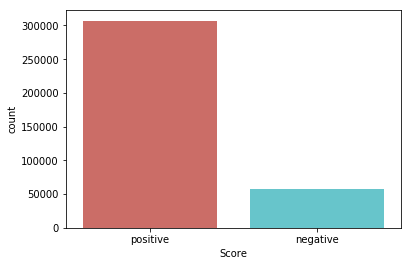

<Figure size 432x288 with 0 Axes>

In [8]:
Class=Sorted["Score"]
label=Sample_sort["Score"]
sns.countplot(x="Score",data=Sorted,palette="hls")
plt.show()
plt.savefig("count_plot")


In [9]:
#Dropping the Score column which are the actual class labels of the dataset
Sorted.drop(columns=['Score'],inplace=True)
Sorted.shape

(364171, 9)

In [10]:
#Dropping the Score column from the sampled_set which are the actual class labels of the dataset
Sample_sort.drop(columns=['Score'],inplace=True)
Sample_sort.shape

(50000, 9)

<h2>Observations</h2>
<ul>
    <li>Here after all the text-preprocesing and the data-cleaning only 364k datapoints remained.</li>
    <li>I have taken a sample size of 50k and also the whole data out of the total population for the purpose of analyzing and studying the behaviour of the data by applying the Naive bayes algorithm.</li>
    <li>First I took the "TIME" column and set as the index of the new sampled dataframe and then sorted accordingly in ascending order since the data has a temporal nature.</li>
    <li>By setting the "SCORE" column as a class label for classifying the reviews as a positive and negative.</li>
    <li>By observing the above bar plot it is clear that the above dataset is highly imbalanced and this may cause problems in the future analysis.</li>
</ul>
    
    

<h3>Function for Spltting the dataset into Train,CV and Test sets (70:30)</h3>

In [11]:
def data_split(x,y):
    #Splitting the model into 70:30 split of Training and Cross_validate split
    X_1, X_test, y_1, y_test = train_test_split(X, Y, test_size=0.3,shuffle=False,random_state=None)

# split the train data set into cross validation train and cross validation test
    X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3,shuffle=False,random_state=None)
    
    return X_tr,y_tr,X_cv,y_cv,X_test,y_test

<h3>Preparing and printing the Train,cv and test sets</h3>

In [12]:

X=Sorted
Y=Class

X_tr,y_tr,X_cv,y_cv,X_test,y_test=data_split(X,Y)

print("The shape of x_train is:",X_tr.shape)
print("the shape of y_train is:",y_tr.shape)
print("the shape of x_cv is:",X_cv.shape)
print("the shape of y_cv is:",y_cv.shape)
print("the shape of x_test is:",X_test.shape)
print("the shape of y_test is:",y_test.shape)

The shape of x_train is: (178443, 9)
the shape of y_train is: (178443,)
the shape of x_cv is: (76476, 9)
the shape of y_cv is: (76476,)
the shape of x_test is: (109252, 9)
the shape of y_test is: (109252,)


<h3>Utility function for training and calculating the missclassification error of the model</h3>

In [14]:

#function for training the model
def train(X_tr,Y_tr,X_cv,y_cv):
    
    clf = MultinomialNB()
    clf.fit(X_tr, y_tr)

    pred= clf.predict(X_cv)

    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    
    print('\n The train accuracy by using default alpha over cv set is =  %f%% ' % ( acc))
    return pred,acc

def test(X_tr,y_tr,X_test,y_test):
    Nb = MultinomialNB()
    Nb.fit(X_tr,y_tr)
    pred = Nb.predict(X_test)
    acc = accuracy_score(y_test, pred, normalize=True)*float(100) 
    print('\n**** The Test accuracy by using default alpha is %d%%' % (acc))


def optimal_test(optimal_a,X_tr,y_tr,X_cv,y_cv,X_test,y_test):
    # instantiate learning model a = optimal_alpha
    B_optimal =MultinomialNB(alpha=optimal_a)

# fitting the model
    B_optimal.fit(X_tr, y_tr)

# predict the response
    pred = B_optimal.predict(X_test)

    Y_pred=B_optimal.predict(X_cv)

    TRAIN_acc = accuracy_score(y_cv, Y_pred, normalize=True) * float(100)
    print("\n The train accuracy of the NB classifier for the best alpha=%f%% is %f%% "%(optimal_a,TRAIN_acc))
    
    print("*"*100)

# evaluate accuracy
    Acc = accuracy_score(y_test, pred,normalize=True) * float(100)
    print('\nThe Test accuracy of the NB classifier by using the best alpha = %f%% is %f%%' % (optimal_a, Acc))

    return pred, Acc

def cross_validation(X_cv,y_cv):
    a=[0.001, 0.0001, 0.12, 0.42,0.25,0.50,0.33,0.0065,0.72, 1]
    multinom= a
    cv_Scores=[]
    for a in multinom:
        clf =MultinomialNB(a)
        scores = cross_val_score(clf, X_cv, y_cv, cv=10,scoring='accuracy')
        cv_Scores.append(scores.mean()) 
    #printing the 10 Cross-Validation scores 
    print(cv_Scores)
    return cv_Scores,multinom




<h3>Utility function for visualizing the model scores and CV error of the model</h3>

In [15]:

from sklearn.metrics import confusion_matrix
def Confusion_metric(y_test,y_pred,acc):
    print(metrics.confusion_matrix(y_test,y_pred))
    confusion=metrics.confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(confusion, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Predicted label');
    plt.xlabel('Actual label');
    all_sample_title = 'Accuracy Score: {0}'.format( acc)
    plt.title(all_sample_title, size = 15);
    plt.show()

#Storing the values of the confusion matrix
    TN=confusion[0,0]
    FP=confusion[0,1]
    FN=confusion[1,0]
    TP=confusion[1,1]

# use float to perform true division, not integer division
    Class_acc=((TP + TN) / float(TP + TN + FP + FN))*100

#Code for classification error

    classification_error = ((FP + FN) / float(TP + TN + FP + FN))*100
    

#Code for finding the TPR,FPR,TNR,FNR

    TPR = (TP / float(FN + TP))*100

    FNR = (FN / float(FN + TP))*100

    TNR=(TN / float(TN + FP))*100

    FPR=(FP / float(TN + FP))*100
    
#Code for finding the Precision,Recall & F1_score    
   
    precision = (TP/float(TP+FP))*100
    
    recall= (TP / float(FN + TP))*100
    
    F1_s= ((float(precision*recall)/float(precision+recall))*2)
    
    print()
    
    ptable=PrettyTable()
    ptable.title="The performance metrics of the above model are as follows: "
    ptable.field_names=["Metrics","Scores"]
    ptable.add_row(["Classification_accuracy",Class_acc])
    ptable.add_row(["Classification_error",classification_error])
    ptable.add_row(["True positive",TP])
    ptable.add_row(["False positive",FP])
    ptable.add_row(["True negative",TN])
    ptable.add_row(["False negative",FN])
    ptable.add_row(["True positive rate",TPR])
    ptable.add_row(["False negative rate",FNR])
    ptable.add_row(["True negative rate",TNR])
    ptable.add_row(["False positive rate",FPR])
    ptable.add_row(["Precision value",precision])
    ptable.add_row(["Recall value",recall])
    ptable.add_row(["f1_score value",F1_s])
    
    print(ptable)
    
#Function for plotting the missclassification errors

def MSE_plot(CV_scores,multinom):    
#Calculating the minimum Missclassification error of the above model

    MSE = [1 - x for x in CV_scores]

# determining best a
    optimal_a =multinom[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha value is %f%%.' % optimal_a)

# plot misclassification error vs a 
    plt.plot(multinom, MSE)

    for xy in zip(multinom, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for  alpha value is : ", np.round(MSE,3))
    return optimal_a

    


   

<h3>Utility function for vectorizing the given data & finding the top features</h3>

In [16]:

#Function for vectorizing the train data

from sklearn.preprocessing import StandardScaler
def vec_train(vect,X_tr):
    import warnings
    warnings.filterwarnings("ignore")

    count_vect = vect #in scikit-learn
    BOW = count_vect.fit_transform(X_tr.values)

    return count_vect,BOW


#Function for vectorizing the CV data

def vec_cv(count,X_cv):
    cv=count.transform(X_cv.values)
    cv.get_shape()

    return cv


#Function for vectorizing the test data

def vec_test(count,X_test):
    test=count.transform(X_test.values)
    test.get_shape()

    return test

#Funtion for printing the total number of top features
def top_tfidf_feats(name,row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', name]
    return df




<h3> Bag of words vectorization technique </h3>

In [17]:
#Initializing the count vectorizer 
Count_vect=CountVectorizer(binary=True)

#vectorizing the X_train set
count,x_tr=vec_train(Count_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",x_tr.shape)

#Vectgorizing the X_crossvalidation set
x_cv=vec_cv(count,X_cv["CleanedText"])
print("The shape of the X_cv is: ",x_cv.shape)

#Vectorizing the X_test set
x_test=vec_test(count,X_test["CleanedText"])
print("The shape of the X_test is: ",x_test.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the Bow score are as follows")
features = Count_vect.get_feature_names()
len(features)


top_Bow = top_tfidf_feats("bow",x_tr[1,:].toarray()[0],features,25)
top_Bow




The shape of the X_train is:  (178443, 49468)
The shape of the X_cv is:  (76476, 49468)
The shape of the X_test is:  (109252, 49468)

Top 25 feaures acording to the Bow score are as follows


,feature,bow
0,someth,1
1,teach,1
2,later,1
3,thirti,1
4,day,1
5,rememb,1
6,tradit,1
7,air,1
8,show,1
9,book,1


<h3>Training the NB model using the train set and testing over the CV set with default values</h3>

In [19]:
pred,acc=train(x_tr,y_tr,x_cv,y_cv)


 The train accuracy by using default alpha over cv set is =  81.701449% 


[[ 8563  4486]
 [ 9508 53919]]


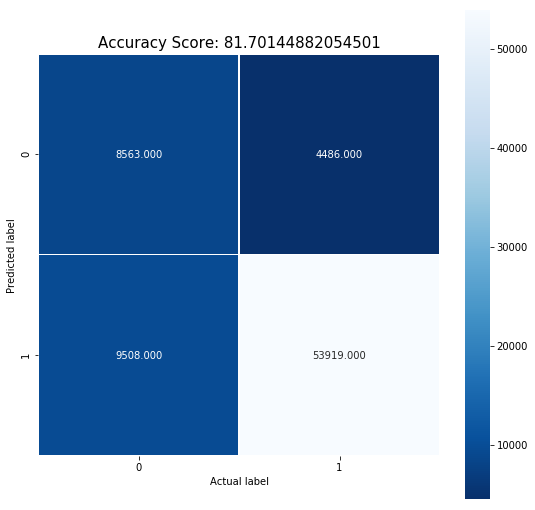


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     81.70144882054501     |
|       Classification_error      |     18.298551179454993    |
|          True positive          |           53919           |
|          False positive         |            4486           |
|          True negative          |            8563           |
|          False negative         |            9508           |
|        True positive rate       |     85.00953852460309     |
|       False negative rate       |     14.990461475396913    |
|        True negative rate       |     65.62188673461567     |
|       False positive rate       |     34.37811326538432     |
|         Precision value         |    

In [26]:
#Confusion metric of the above model:

Confusion_metric(y_cv,pred,acc)

<h3>OBSERVATIONS</h3>
<ul>
    <li>The train accuracy usong default parameters of the model is 81.70% which is not that good for a classification model.</li>
    <li>Here the TP is dominating metric as compared to other metric which also results in high TPR value.</li>
    <li>Due to the low TN value the TNR value is very less (65.52%) which is not a good sign for aclassification model.</li>
    <li>The precision,recall and the f1_score cannot be trusted due to high TPR & low TNR values.</li>

<h3>Hyperparameter tuning the alpha value by using 10-fold Cross-validation technique</h3>

In [27]:
Score,mutinom =cross_validation(x_tr,y_tr)

[0.7844576677081012, 0.7847770971595364, 0.7819526695323858, 0.7803667330368377, 0.781028009694429, 0.780030493409807, 0.7807029745481355, 0.7839196792801396, 0.7794869039976551, 0.7788928809182714]



The optimal number of alpha value is 0.000100%.


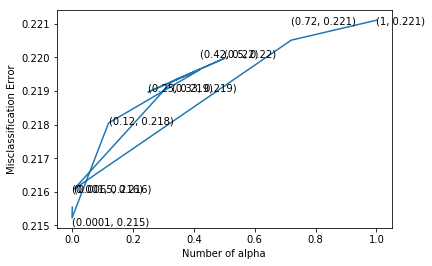

the misclassification error for  alpha value is :  [0.216 0.215 0.218 0.22  0.219 0.22  0.219 0.216 0.221 0.221]


In [28]:
optimal_a=MSE_plot(Score,mutinom) #CODE FOR PLOTTING THE ERROR PLOT

<h3> Testing the model by using the optimal alpha over the test set</h3>

In [29]:

#Testing the model with default value of alpha over the Test data
test(x_tr,y_tr,x_test,y_test)

print("*"*100)

#Testing the model with optimal alpha value over the test data
y_pred,Test_acc,=optimal_test(optimal_a,x_tr,y_tr,x_cv,y_cv,x_test,y_test)


**** The Test accuracy by using default alpha is 81%
****************************************************************************************************

 The train accuracy of the NB classifier for the best alpha=0.000100% is 81.633454% 
****************************************************************************************************

The Test accuracy of the NB classifier by using the best alpha = 0.000100% is 81.199429%


<h3>Confusion metric of the above model.</h3>

[[12227  6854]
 [13686 76485]]


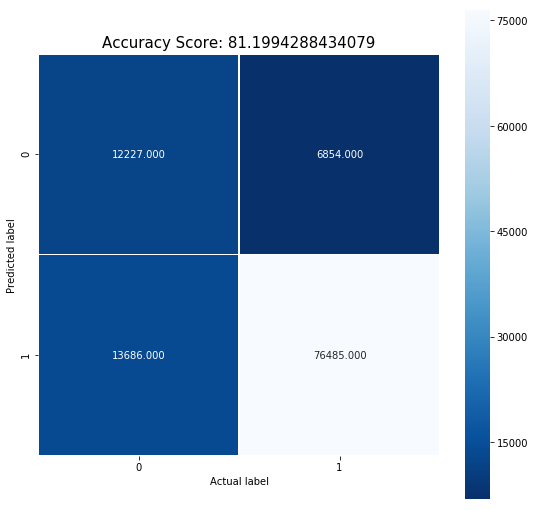


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |      81.1994288434079     |
|       Classification_error      |      18.8005711565921     |
|          True positive          |           76485           |
|          False positive         |            6854           |
|          True negative          |           12227           |
|          False negative         |           13686           |
|        True positive rate       |     84.82217120803807     |
|       False negative rate       |     15.17782879196194     |
|        True negative rate       |     64.07945076253864     |
|       False positive rate       |     35.920549237461344    |
|         Precision value         |    

In [30]:
Confusion_metric(y_test,y_pred,Test_acc)

<h2>OBSERVATION</h2>
<ul>
    <li>After training the model over optimal alpha value the model score decreased by 0.51% which is not good.</li>
    <li>This model scores are also similar to the previous model except there is slight decrease is seen on all the parameters.</li>
    <li>Since the model is trained over imbalanced dataset so the it is suffering from the high bias problem.</li>
    <li>So the performance can be increased if data balancing is performed over the dataset which can be done by using the oversampling technique.</li>


<h3> Oversampling the data by using the SMOTE technique</h3>

In [31]:
#FUNCTION FOR IMPLEMENTING THE SYNTHETIC MINORITY OVERSAMPLING TECHNIQUE
from imblearn.over_sampling import SMOTE 

def Bal_train (X_tr, y_tr,X_cv,y_cv,X_test,y_test):
  
    sm = SMOTE()
    X_Train_res, y_Train_res = sm.fit_sample(X_tr, y_tr)
    X_Cval_res,y_Cval_res=sm.fit_sample(X_cv,y_cv)
    X_Test_res,y_Test_res=sm.fit_sample(X_test,y_test)
    
    
    clf = MultinomialNB()
    clf.fit(X_Train_res, y_Train_res )

    pred= clf.predict(X_Cval_res)

    acc = accuracy_score(y_Cval_res, pred, normalize=True) * float(100)
    
    print('\n The TRAIN accuracy by using default alpha over CV set is =  %f%% ' % ( acc))
    
    return X_Train_res, y_Train_res,X_Cval_res,y_Cval_res,X_Test_res,y_Test_res,pred, acc



<h3> Training the SMOTE model</h3>

In [34]:
bal_xtr,bal_ytr,bal_xcv,bal_ycv,bal_xtes,bal_ytes,b_pre,b_acc=Bal_train(x_tr,y_tr,x_cv,y_cv,x_test,y_test)


 The TRAIN accuracy by using default alpha over CV set is =  76.550996% 


[[45707 17720]
 [12026 51401]]


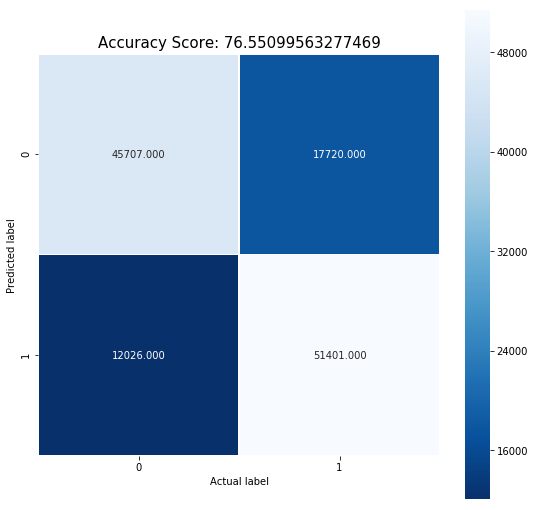


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     76.55099563277469     |
|       Classification_error      |     23.449004367225314    |
|          True positive          |           51401           |
|          False positive         |           17720           |
|          True negative          |           45707           |
|          False negative         |           12026           |
|        True positive rate       |     81.03962035095465     |
|       False negative rate       |     18.960379649045358    |
|        True negative rate       |     72.06237091459474     |
|       False positive rate       |     27.93762908540527     |
|         Precision value         |    

In [35]:
Confusion_metric(bal_ycv,b_pre,b_acc)

<h3>HYPERAMETER TUNING THE ALPHA FOR FINDING THE OPTIMAL ALPHA VALUE </h3>

In [36]:
BScore,Mutinom =cross_validation(bal_xtr,bal_ytr)

[0.83896452215018, 0.8389808128280135, 0.8388504880422468, 0.8387885845704425, 0.8388374561793419, 0.8387820682143887, 0.8388179073234815, 0.8389319412191141, 0.8387592616051028, 0.8387462288929954]



The optimal number of alpha value is 0.000100%.


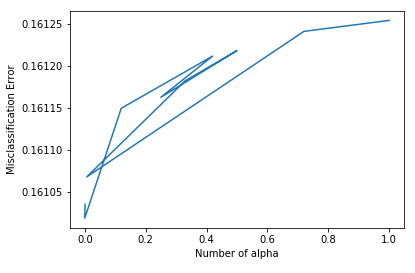

the misclassification error for  alpha value is :  [0.161 0.161 0.161 0.161 0.161 0.161 0.161 0.161 0.161 0.161]


In [37]:
Boptimal_a=MSE_plot(BScore,Mutinom) #CODE FOR PLOTTING THE ERROR PLOT

<h3> Testing the model by using the optimal alpha over the test set</h3>

In [38]:
#Testing the model with default value of alpha over the Test data
test(bal_xtr,bal_ytr,bal_xtes,bal_ytes)

print("*"*100)

#Testing the model with optimal alpha value over the test data
Y_pred,BalTest_acc,=optimal_test(Boptimal_a,bal_xtr,bal_ytr,bal_xcv,bal_ycv,bal_xtes,bal_ytes)


**** The Test accuracy by using default alpha is 76%
****************************************************************************************************

 The train accuracy of the NB classifier for the best alpha=0.000100% is 76.275876% 
****************************************************************************************************

The Test accuracy of the NB classifier by using the best alpha = 0.000100% is 75.777689%


[[63453 26718]
 [16965 73206]]


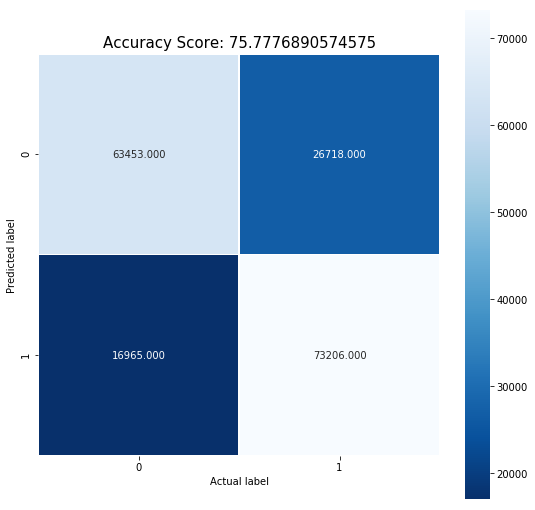


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |      75.7776890574575     |
|       Classification_error      |     24.222310942542503    |
|          True positive          |           73206           |
|          False positive         |           26718           |
|          True negative          |           63453           |
|          False negative         |           16965           |
|        True positive rate       |     81.18574708054696     |
|       False negative rate       |     18.81425291945304     |
|        True negative rate       |     70.36963103436803     |
|       False positive rate       |     29.630368965631966    |
|         Precision value         |    

In [39]:
Confusion_metric(bal_ytes,Y_pred,BalTest_acc)

<h2>OBSERVATION</h2>
<ul>
    <li>After oversampling the data the accuracy of the model reduced (from 81% to 75%) as compared to the previous model but the model is very stable and sensible because of high TP and TN values.</li>
    <li>There is a considerable increase in the TNR value (64%-70.36%)& considerable decrease in the FPR value(34% to 29.63%) which is a good sign for the improvement of the model.</li>
    <li>So the model is sensible and stable as compared to the previous model which is achieved by balanciing the data.</li>
    <li>The metric as accuracy is very misleading and can't be trusted in a imbalanced data.</li>

<h3>Implemnting the Tf-idf vectorizeration technique</h3>

In [67]:
#Initializing the count vectorizer 
TF_vect=TfidfVectorizer(ngram_range=(1,2),binary=True)

#vectorizing the X_train set
TF_count,X_tr=vec_train(TF_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",X_tr.shape)

#Vectgorizing the X_crossvalidation set
X_cv=vec_cv(TF_count,X_cv["CleanedText"])
print("The shape of the X_cv is: ",X_cv.shape)

#Vectorizing the X_test set
X_test=vec_test(TF_count,X_test["CleanedText"])
print("The shape of the X_test is: ",X_test.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the Bow score are as follows")
Features = TF_vect.get_feature_names()
len(Features)


top_tfidf = top_tfidf_feats("tfidf",X_tr[1,:].toarray()[0],Features,25)
top_tfidf




The shape of the X_train is:  (178443, 1816552)
The shape of the X_cv is:  (76476, 1816552)
The shape of the X_test is:  (109252, 1816552)

Top 25 feaures acording to the Bow score are as follows


,feature,tfidf
0,preschool turn,422.426325
1,teach preschool,422.426325
2,whole school,422.426325
3,school purchas,422.426325
4,sister later,422.426325
5,song student,422.426325
6,air televis,422.426325
7,child sister,422.426325
8,book song,422.426325
9,use seri,372.605606


<h3>Training the Tf-idf vectorized model over the CV set.</h3> 

In [41]:
Predi,Acc=train(X_tr,y_tr,X_cv,y_cv)


 The train accuracy by using default alpha over cv set is =  85.608557% 


<h3>Confusion metric of the above model.</h3>

[[ 4064  8985]
 [ 2021 61406]]


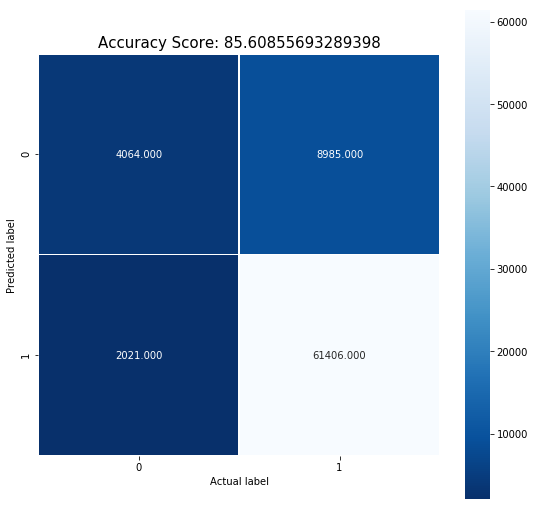


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     85.60855693289398     |
|       Classification_error      |     14.39144306710602     |
|          True positive          |           61406           |
|          False positive         |            8985           |
|          True negative          |            4064           |
|          False negative         |            2021           |
|        True positive rate       |     96.81365979787788     |
|       False negative rate       |     3.1863402021221248    |
|        True negative rate       |      31.1441489769331     |
|       False positive rate       |      68.8558510230669     |
|         Precision value         |    

In [42]:
Confusion_metric(y_cv,Predi,Acc)

<h2>OBSERVATION</h2>
<ul>
    <li>The accuracy of the model by using the default alpha value is 85.60% which is good but the other metrics are very less and very alarming.</li>
    <li>In this model the TP value is very dominating which results in high TPR rate as compared to the other metrics which is not good as the model will become biased towards positive reviews.</li>
    <li>The TNR is very less and this model will fail to clasiffy the negative reviews properly.</li>
    <li>Let's see if the metrics become better after doing hyper-parameter tuning the alpha value.</li>

<h3>HYPERAMETER TUNING THE ALPHA FOR FINDING THE OPTIMAL ALPHA VALUE </h3>

In [43]:
CV_Score,Mutinomi =cross_validation(X_tr,y_tr)

[0.8456538275213425, 0.850350012363933, 0.7999472979891289, 0.7642888248070557, 0.781392345001281, 0.7573846559978202, 0.7729134422929673, 0.8363399278287986, 0.742136071851881, 0.7267473805074696]



The optimal number of alpha value is 0.000100%.


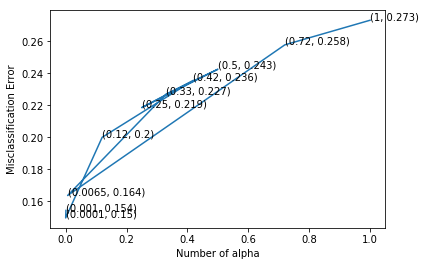

the misclassification error for  alpha value is :  [0.154 0.15  0.2   0.236 0.219 0.243 0.227 0.164 0.258 0.273]


In [44]:
Optimal_a=MSE_plot(CV_Score,Mutinomi) #CODE FOR PLOTTING THE ERROR PLOT

<h3> Testing the model by using the optimal alpha over the test set</h3>

In [45]:
#Testing the model with default value of alpha over the Test data
test(X_tr,y_tr,X_test,y_test)

print("*"*100)

#Testing the model with optimal alpha value over the test data
Y_prediction,Test_accuracy=optimal_test(Optimal_a,X_tr,y_tr,X_cv,y_cv,X_test,y_test)


**** The Test accuracy by using default alpha is 84%
****************************************************************************************************

 The train accuracy of the NB classifier for the best alpha=0.000100% is 84.246038% 
****************************************************************************************************

The Test accuracy of the NB classifier by using the best alpha = 0.000100% is 83.790686%


<h3>Confusion metric of the above model.</h3>

[[ 3501 15580]
 [ 2129 88042]]


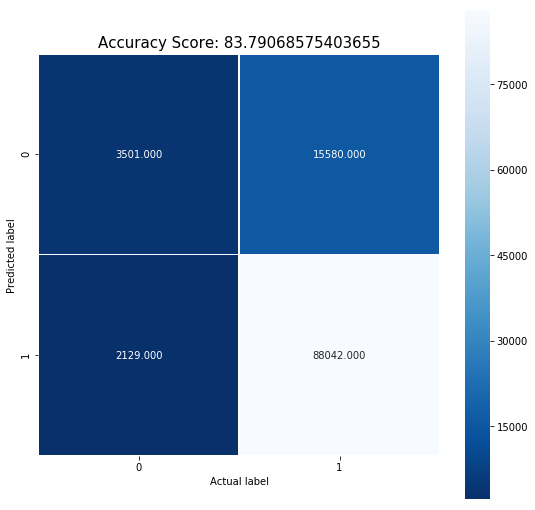


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     83.79068575403655     |
|       Classification_error      |     16.209314245963462    |
|          True positive          |           88042           |
|          False positive         |           15580           |
|          True negative          |            3501           |
|          False negative         |            2129           |
|        True positive rate       |     97.63893047653902     |
|       False negative rate       |      2.36106952346098     |
|        True negative rate       |     18.348094963576333    |
|       False positive rate       |     81.65190503642367     |
|         Precision value         |    

In [46]:
Confusion_metric(y_test,Y_prediction,Test_accuracy)

<h2>Observations</h2>
<ul>
    <li>The accuracy of the model has become low after tuning the alpha which is not good for a classification model.
    <li>The main reason is because of the high FPR and low TNR which affects the model a lot.
    <li>This model is also suffering from the heavy bias problem and may be solved by oversampling the datapoints.</li>
    <li>The high Precision,recall and f1_score value cannot be trusted because of high tpr as compared to other metrics.</li>


<h3> Oversampling the data by using the SMOTE technique</h3>

In [47]:
Bal_xtr,Bal_ytr,Bal_xcv,Bal_ycv,Bal_xtes,Bal_ytes,B_pre,B_acc=Bal_train(X_tr,y_tr,X_cv,y_cv,X_test,y_test)


 The TRAIN accuracy by using default alpha over CV set is =  62.409542% 


<h3>Confusion metric of the above model.</h3>

[[17149 46278]
 [ 1407 62020]]


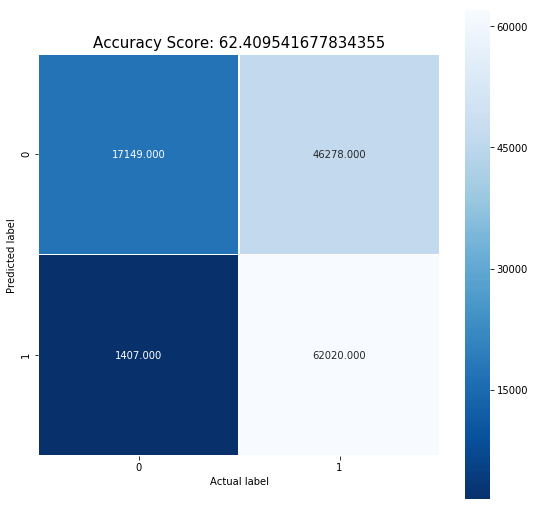


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     62.409541677834355    |
|       Classification_error      |     37.59045832216564     |
|          True positive          |           62020           |
|          False positive         |           46278           |
|          True negative          |           17149           |
|          False negative         |            1407           |
|        True positive rate       |     97.78170179891845     |
|       False negative rate       |     2.2182982010815584    |
|        True negative rate       |     27.03738155675028     |
|       False positive rate       |     72.96261844324971     |
|         Precision value         |    

In [48]:
Confusion_metric(Bal_ycv,B_pre,B_acc)

<h3>HYPERAMETER TUNING THE ALPHA FOR FINDING THE OPTIMAL ALPHA VALUE </h3>

In [49]:
BScoreS,Mutinomial =cross_validation(Bal_xtr,Bal_ytr)

[0.9823736553630698, 0.9827581127274145, 0.9804546256578697, 0.9791383491218069, 0.9797704214348719, 0.978907023152515, 0.9794218046657244, 0.9818979690139731, 0.9783401129138823, 0.977802524154485]



The optimal number of alpha value is 0.000100%.


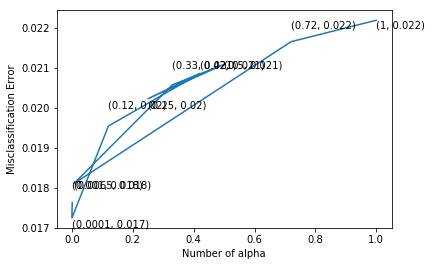

the misclassification error for  alpha value is :  [0.018 0.017 0.02  0.021 0.02  0.021 0.021 0.018 0.022 0.022]


In [50]:
Bal_optimal_a=MSE_plot(BScoreS,Mutinomial) #CODE FOR PLOTTING THE ERROR PLOT

<h3> Testing the model by using the optimal alpha over the test set</h3>

In [51]:
#Testing the model with default value of alpha over the Test data
test(Bal_xtr,Bal_ytr,Bal_xtes,Bal_ytes)

print("*"*100)

#Testing the model with optimal alpha value over the test data
Y_PRED,BalTest_Acc=optimal_test(Bal_optimal_a,Bal_xtr,Bal_ytr,Bal_xcv,Bal_ycv,Bal_xtes,Bal_ytes)


**** The Test accuracy by using default alpha is 61%
****************************************************************************************************

 The train accuracy of the NB classifier for the best alpha=0.000100% is 57.949296% 
****************************************************************************************************

The Test accuracy of the NB classifier by using the best alpha = 0.000100% is 57.969857%


<h3>Confusion metric of the above model.</h3>

[[16221 73950]
 [ 1848 88323]]


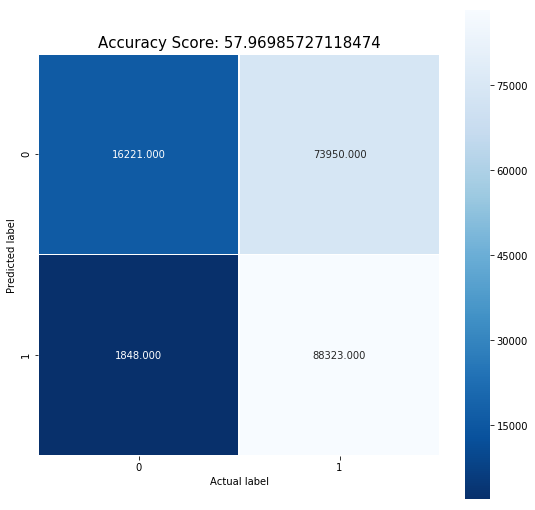


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     57.96985727118474     |
|       Classification_error      |     42.03014272881525     |
|          True positive          |           88323           |
|          False positive         |           73950           |
|          True negative          |           16221           |
|          False negative         |            1848           |
|        True positive rate       |     97.95056060152378     |
|       False negative rate       |     2.0494393984762285    |
|        True negative rate       |     17.989153940845725    |
|       False positive rate       |     82.01084605915428     |
|         Precision value         |    

In [52]:
Confusion_metric(Bal_ytes,Y_PRED,BalTest_Acc)

<h2> Observations:</h2>
<ul>
    <li>Since after doing the data balancing technique the model score decreased very drastically due to poor performance metrics.
    <li>I think the model is overfitting which leads to decrease in accuracy and other factor may be the high dimensions of the tf-idf vectorized data.
    <li>In this model SMOTE didn't improved the model in terms of stability and accuracy.</li>
    